In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from glob import glob
import linecache
import datetime as dt
import os
import matplotlib.pyplot as plt

In [2]:
def process_is_icartt(file_path):
    with open(file_path, 'r') as file:
        # Read the seventh line
        for _ in range(6):
            file.readline()
        date_line = file.readline()

        # Convert to a pandas datetime object
        file_date = pd.to_datetime(date_line[:10]
                                   , format='%Y,%m,%d').date()

        # Skip lines up to and including line 49
        for _ in range(49):
            file.readline()

        # Remove blank lines
        lines = [line.strip() for line in file.readlines() if line.strip()]

    # Remove lines with NaN
    lines = [line for line in lines if 'NaN' not in line]

    # Split lines into 5 numbers and create a DataFrame
    data = [list(map(lambda x: float(x) if x else np.nan, line.split(','))) for line in lines]

    columns = ["temp", "n_INP", "n_INP_low_CI", "n_INP_high_CI", "heat_treat"]
    df = pd.DataFrame(data, columns=columns).set_index("temp")
    # Drop rows where heat_treat is not 0
    df = df[df['heat_treat'] == 0]

    return df, file_date


In [3]:
def process_directory(directory_path, comble_flag = False):
    # Initialize empty lists to store dataframes and dates
    dfs = []
    dates = []


    if comble_flag:
        comble_times = pd.read_csv('/home/users/erinraif/acao_data/other_campaigns/comble_cao_timings.csv')
        comble_times['start_time'] = pd.to_datetime(comble_times['start_time'], format='%y/%m/%d %H:%M')
        comble_times['end_time'] = pd.to_datetime(comble_times['end_time'], format='%y/%m/%d %H:%M')
        comble_filters = pd.DataFrame(columns=['filename', 'start_time', 'end_time'])
        comble_files = glob('/home/users/erinraif/acao_data/other_campaigns/comble_cao/*.ict')
        for file in comble_files:
            date = file[-15:-7]
            year, month, day, _, _, _ = linecache.getline(file, 7).split(',')
            start_midnight = dt.datetime(int(year), int(month), int(day))
            line_45 = linecache.getline(file, 45)
            start_spm, end_spm, _ = line_45.split(', ')
            start_delta = dt.timedelta(seconds=int(start_spm))
            end_delta = dt.timedelta(seconds=int(end_spm))
            start_time = start_midnight + start_delta
            end_time = start_midnight + end_delta
            new_row = pd.Series({'filename': file, 'start_time': start_time, 'end_time': end_time})
            comble_filters = pd.concat([comble_filters, new_row.to_frame().T], ignore_index=True)
        comble_filters['day_str'] = comble_filters['filename'].str[-15:-7]
        # Assuming you have two DataFrames: comble_filters and comble_times

        # Create an empty dictionary to store the total time of CAO events for each filter
        total_cao_times = {}
        
        # Iterate over each row in comble_filters
        for index, row in comble_filters.iterrows():
            filter_start_time = row['start_time']
            filter_end_time = row['end_time']
            # Filter comble_times to find CAO events that overlap with the current filter's time range
            overlapping_cao_events = comble_times[
                (comble_times['start_time'] < filter_end_time) & 
                (comble_times['end_time'] > filter_start_time)
            ]
            
            # Calculate the total time the filter was inside a CAO event
            total_time_within_cao = dt.timedelta(0)
            for _, cao_row in overlapping_cao_events.iterrows():
                cao_start_time = max(cao_row['start_time'], filter_start_time)
                cao_end_time = min(cao_row['end_time'], filter_end_time)
                total_time_within_cao += cao_end_time - cao_start_time
            
            # Store the total time in the dictionary
            total_cao_times[row['filename']] = total_time_within_cao
        
        # Convert the dictionary to a DataFrame for easier manipulation
        total_cao_times_df = pd.DataFrame(list(total_cao_times.items()), columns=['filename', 'total_cao_time'])
        cao_filters = list(total_cao_times_df[total_cao_times_df['total_cao_time'] >= dt.timedelta(hours=12)]['filename'])

        # Loop through each cao condition file
        for filename in cao_filters:
            if filename.endswith(".ict"):
                # Process the file and get dataframe, date
                df, file_date = process_is_icartt(filename)
    
                # Append to lists
                dfs.append(df)
                dates.append(file_date)
        
    else:
        # Loop through each file in the directory
        for filename in os.listdir(directory_path):
            if filename.endswith(".ict"):
                # Process the file and get dataframe, date
                file_path = os.path.join(directory_path, filename)
                df, file_date = process_is_icartt(file_path)
    
                # Append to lists
                dfs.append(df)
                dates.append(file_date)
    # Concatenate dataframes along the time dimension
    combined_df = pd.concat(dfs, keys=dates, names=['time'])
    # Get rid of datapoints that are duplicated
    combined_df = combined_df[~combined_df.index.duplicated(keep=False)]
    # Convert the combined dataframe to xarray dataset
    ds = xr.Dataset.from_dataframe(combined_df)

    return ds

In [4]:
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

def get_season_color(season):
    # Specify colors for each season
    season_colors = {'Spring': 'tab:green', 'Summer': 'tab:orange', 'Autumn': 'tab:brown', 'Winter': 'tab:blue'}
    return season_colors.get(season, 'black')

In [5]:
def plot_creamean_drum():
    creamean_drum = pd.read_csv('/home/users/erinraif/acao_data/other_campaigns/creamean2022.csv', index_col=0)
    
    # Extract date information from column names
    creamean_drum.columns = pd.to_datetime(creamean_drum.columns.str.split('_').str[1],
                                           format='%Y%m%d')
    
    # Calculate the sum of concentrations for each date
    creamean_drum_sum = creamean_drum.groupby(creamean_drum.columns, axis=1).sum()
    
    creamean_drum_sum.replace(0, np.nan, inplace=True)
    
    for column in creamean_drum_sum.columns:
        month = column.month
        if month in (3,4):
            color = 'darkgreen'
        else:
            color = 'tab:brown'
        creamean_drum_sum[column].plot(markersize=2, marker='x', linestyle='',
                                       ax=ax, color=color,label='_',zorder=2)
    return


In [6]:
def plot_acao():
    acao = pd.read_csv('/home/users/erinraif/acao_data/inp_data/INP_concentrations.csv', index_col='temp_bin')
    for col in [col for col in acao.columns if col.endswith('NT')]:
        y = acao[col]
        ax.plot(y.dropna().index, y.dropna(), 
                    linewidth=1, color='k',zorder=100)
    return

In [7]:
comble_is = process_directory('/home/users/erinraif/acao_data/other_campaigns/comble', True)
comble_is['time'] = pd.to_datetime(comble_is['time'].values)
def plot_comble(ds):
    # Extract the unique dates in the dataset
    unique_dates = np.unique(ds['time'].dt.date)

    # Plot for each day in spring
    for date in unique_dates:
        ds_day = ds.sel(time=str(date))
        ax.plot(ds_day['n_INP'].dropna('temp').temp, ds_day['n_INP'].dropna('temp'),linewidth=1,linestyle='-',color='tab:blue',
               zorder=3.5)

In [8]:
def plot_hartmann20():
    df = pd.read_csv('/home/users/erinraif/acao_data/other_campaigns/hartmann2020_v2.csv')
    for i in (1,2,3):
        ax.scatter(df['temp'+str(i)],df['conc'+str(i)], marker='o',s=4,color='tab:red',zorder=6)

In [9]:
def plot_hartmann21():
    df = pd.read_csv('/home/users/erinraif/acao_data/other_campaigns/hartmann2021.csv')
    for col in df:
        ax.scatter(df['temp'],df[col],s=2,marker='2',color='tab:orange',linewidth=0.5,zorder=1)

In [10]:
def plot_prenni07():
    df = pd.read_csv('/home/users/erinraif/acao_data/other_campaigns/prenni2007.csv')
    for col in df:
        ax.scatter(df['temp'],df['conc'],s=14,marker='p',color='darkcyan',zorder=10)

In [11]:
def plot_rogers01():
    df = pd.read_csv('/home/users/erinraif/acao_data/other_campaigns/rogers2001.csv')
    for col in df:
        ax.scatter(df['temp'],df['conc'],s=12,marker='d',color='olivedrab',zorder=10.5)

In [12]:
def plot_sm20():
    df = pd.read_csv('/home/users/erinraif/acao_data/other_campaigns/sm2020.csv')
    for i in range(12):
        ax.plot(df['temp'+str(i+1)],df['conc'+str(i+1)], linewidth=1,color='tab:red',zorder=9)
    

In [13]:
def read_wex():
    df = pd.read_csv('/home/users/erinraif/acao_data/other_campaigns/wex_nyalesund.tab',delimiter='\t')
    #print(df.columns)
    # Select and rename columns
    df = df[['Sample label (in home_laboratory)', 'T tech [°C]', 'N INP [#/l]']]
    df.columns = ['Date', 'Temp', 'n_INP']
    
    # Convert 'Date' to datetime object
    df['Date'] = pd.to_datetime(df['Date'], format='%d_%m_%y')

    df = df[df['n_INP'] != 0]
    
    # Display the resulting dataframe
    #print(df.head())

read_wex()
    

In [14]:
def plot_wex(csv):
    #'/home/users/erinraif/acao_data/other_campaigns/wex_nyalesund.tab'
    df = pd.read_csv(csv,delimiter='\t')
    # Select and rename columns
    df = df[['Sample label (in home_laboratory)', 'T tech [°C]', 'N INP [#/l]']]
    df.columns = ['Date', 'Temp', 'n_INP']
    
    # Convert 'Date' to datetime object
    df['Date'] = pd.to_datetime(df['Date'], format='%d_%m_%y')

    df = df[df['n_INP'] != 0]
    for date, group in df.groupby('Date'):
        # Set color based on month
        color = 'deeppink' if date.month in [3, 4] else 'purple'
        zorder = 4 if date.month in [3,4] else 5
        # Plot 'Temp' against 'n_INP'
        ax.plot(group['Temp'], group['n_INP'], color=color,linewidth=1, zorder=zorder)

    

In [15]:
def plot_wex_gray(csv):
    #'/home/users/erinraif/acao_data/other_campaigns/wex_nyalesund.tab'
    df = pd.read_csv(csv,delimiter='\t')
    # Select and rename columns
    df = df[['Date/Time (start)', 'T tech [°C]', 'N INP [#/l]']]
    df.columns = ['Date', 'Temp', 'n_INP']
    
    # Convert 'Date' to datetime object
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M')

    df = df[df['n_INP'] != 0]
    for date, group in df.groupby('Date'):
        ax.plot(group['Temp'], group['n_INP'], color='darkgray',linewidth=1,zorder=3)

In [16]:
def plot_petters():
    df = pd.read_csv('/home/users/erinraif/acao_data/other_campaigns/petters_and_wright2015.csv')
    ax.fill( # Petters curve
        np.append(df['lower_temp'], df['upper_temp'][::-1]),
        np.append(df['lower_conc'], df['upper_conc'][::-1]),
    #color = '#ffffff', alpha = 0.4, edgecolor = 'lightgrey',
    color = 'lightgrey', alpha = 0.7, edgecolor = 'lightgrey',
    zorder=0,linestyle='-')

In [17]:
def plot_leeds_style(csv, color,z):
    df = pd.read_csv(csv, header=None)
    
    # Loop through the dataframe two columns at a time
    for i in range(0, len(df.columns), 2):
        subset = df.iloc[:, i:i+2]
        # Process the subset (replace print with your processing logic)
        ax.plot(subset.iloc[:,0], subset.iloc[:,1], color=color,linewidth=1,zorder=z)

In [18]:
def plot_rinaldi():
    df = pd.read_csv('/home/users/erinraif/acao_data/other_campaigns/rinaldi_2021_WT-craft.txt',
                    delimiter='\t', skiprows=[1],
                    usecols=lambda x: x not in ['Sample ID #', 'Filter Sampling Start Time', 'Filter Sampling End Time'],
                    nrows=28)

    df.columns = [float(col[5:-2]) for col in df.columns]

    # Replace the "<dl" strings with NaN
    df.replace('<dl', pd.NA, inplace=True)
    df = df.T
    df.index = df.index.astype(float)
    for col in df.columns:
        ax.plot(df[col].dropna().index, df[col].dropna().astype(float)/1000,
                linewidth=0, marker='+',markersize=3,color='teal',zorder=11)

    df = pd.read_csv('/home/users/erinraif/acao_data/other_campaigns/rinaldi_2021_DPFC.txt',
                    delimiter='\t', skiprows=[1,18],
                    usecols=lambda x: x in ['nINP_PM10_-15°C', 'nINP_PM10_-18°C', 'nINP_PM10_-22°C'],
                    nrows=33)

    df.columns = [float(col[-5:-2]) for col in df.columns]

    # Replace the "<dl" strings with NaN
    df.replace('<dl', pd.NA, inplace=True)
    df.replace('NA', pd.NA, inplace=True)
    df = df.T
    df.index = df.index.astype(float)
    for col in df.columns:
        ax.plot(df[col].dropna().index, df[col].dropna().astype(float)/1000,
                linewidth=0, marker='+',markersize=3,color='teal',zorder=11)
    return

In [19]:
def plot_li():
    df = pd.read_csv('/home/users/erinraif/acao_data/other_campaigns/li2023.csv')
    df = df[df['Sample_type']!='PM10']
    ax.scatter(df['Temperature'], df['N_INP'], s=2.4,marker='v',color='darkslateblue',zorder=15)
    return

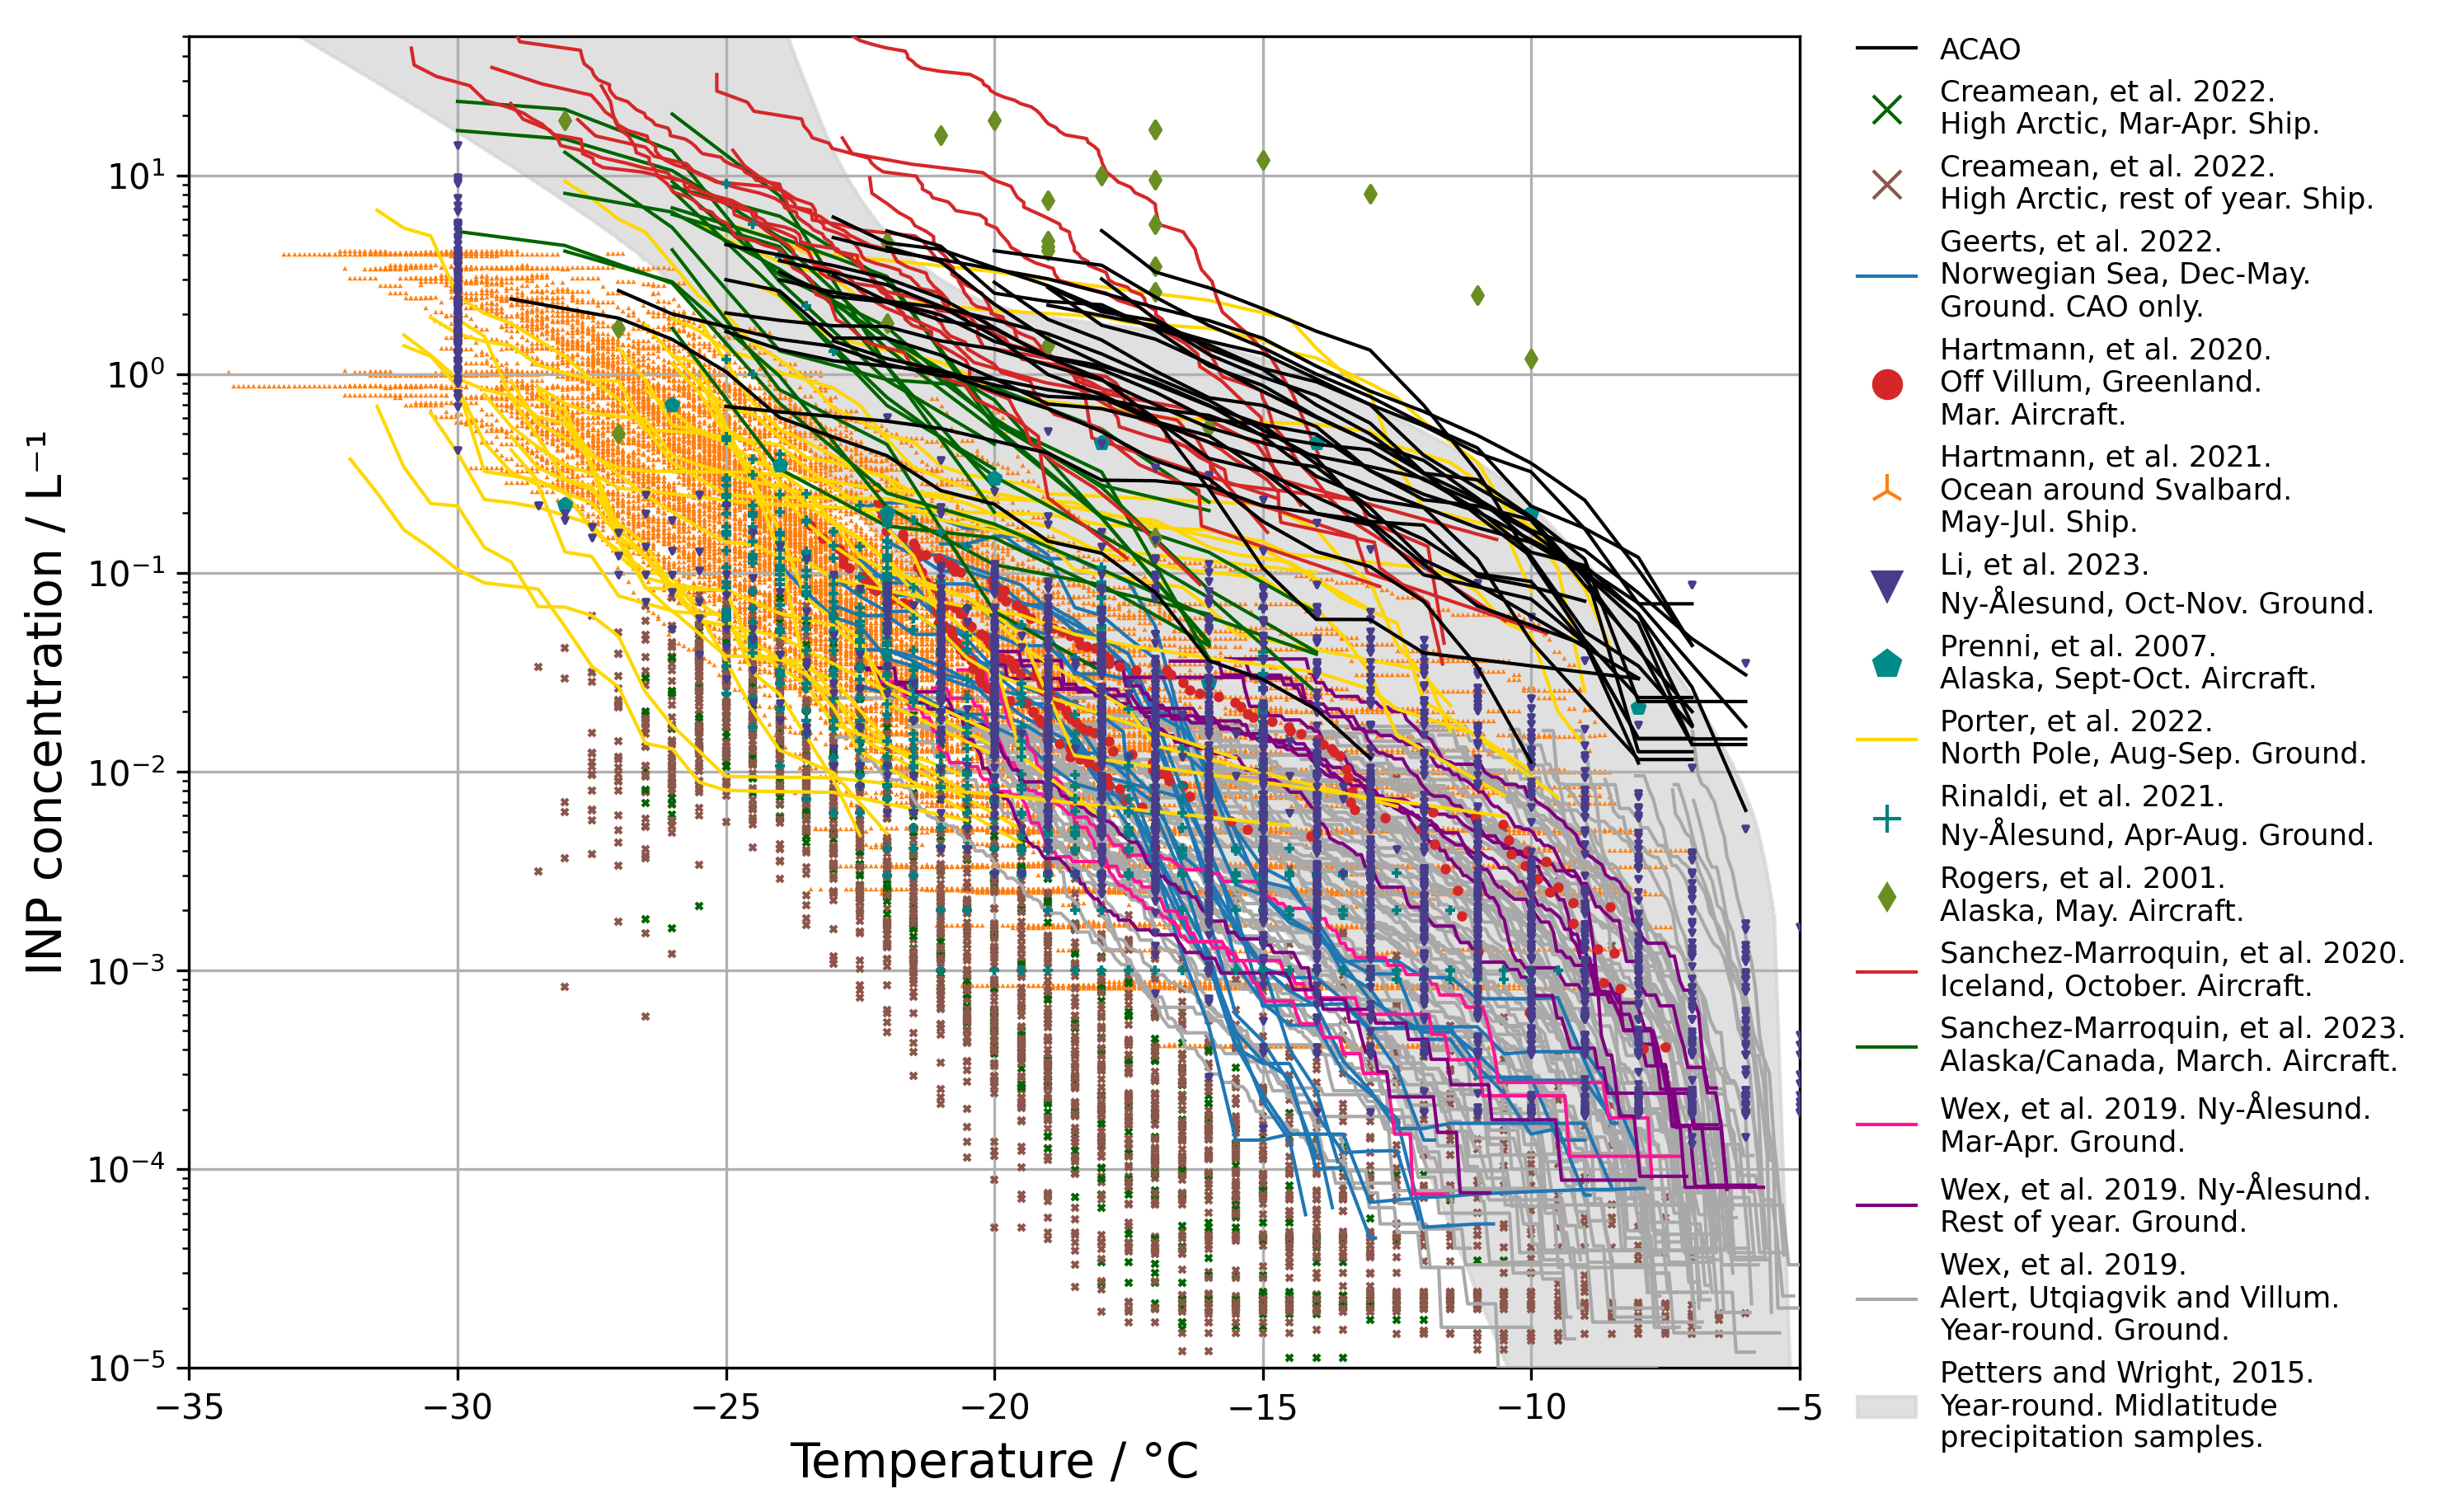

In [21]:
fig, ax = plt.subplots(figsize=(10,6.5),dpi=300)
# apologies for this terrible practice, couldn't be bothered to change my functions to take an ax argument!
#plot_seasons(creamean_is)
plot_petters()
plot_acao()
plot_creamean_drum()
plot_hartmann21()
plot_sm20()
plot_rogers01()
plot_wex_gray('/home/users/erinraif/acao_data/other_campaigns/wex_alert.tab')
plot_wex_gray('/home/users/erinraif/acao_data/other_campaigns/wex_utqiagvik.tab')
plot_wex_gray('/home/users/erinraif/acao_data/other_campaigns/wex_villum.tab')
plot_comble(comble_is)
plot_wex('/home/users/erinraif/acao_data/other_campaigns/wex_nyalesund.tab')
plot_leeds_style('/home/users/erinraif/acao_data/other_campaigns/sm_north_america2023.csv', 'darkgreen',8)
plot_leeds_style('/home/users/erinraif/acao_data/other_campaigns/porter2022_v2.csv', 'gold',7)
plot_hartmann20()
plot_prenni07()
plot_rinaldi()
plot_li()
ax.set_yscale('log')
ax.set_xlabel('Temperature / \u00b0C',fontsize=14)
ax.set_ylabel('INP concentration / L⁻¹',fontsize=14)
ax.set_xlim(-35, -5)
ax.set_ylim(1e-5,50)
ax.grid()


# Artificially create legend
ax.plot([0], [1], linewidth=1, color='k', label='ACAO')
ax.plot([0], [1], markersize=8, marker='x', linestyle='',
        color='darkgreen', label='Creamean, et al. 2022.\nHigh Arctic, Mar-Apr. Ship.')
ax.plot([0], [1], markersize=8, marker='x', linestyle='',
        color='tab:brown', label='Creamean, et al. 2022.\nHigh Arctic, rest of year. Ship.')
ax.plot([0], [1], linewidth=1, linestyle='-',
        color='tab:blue', label='Geerts, et al. 2022.\nNorwegian Sea, Dec-May.\nGround. CAO only.')
ax.plot([0],[1], marker='o',markersize=8, linewidth=0,
        color='tab:red',label='Hartmann, et al. 2020.\nOff Villum, Greenland.\nMar. Aircraft.')
ax.plot([0],[1],linewidth=0,markersize=10,marker='2',color='tab:orange',markeredgewidth=1,
       label='Hartmann, et al. 2021.\nOcean around Svalbard.\nMay-Jul. Ship.')
ax.plot([0],[1],markersize=8,linewidth=0,marker='v',
        color='darkslateblue',label='Li, et al. 2023.\nNy-Ålesund, Oct-Nov. Ground.')
ax.plot([0],[1],markersize=8,linewidth=0,marker='p',
        color='darkcyan',label='Prenni, et al. 2007.\nAlaska, Sept-Oct. Aircraft.')
ax.plot([0], [1], linewidth=1, linestyle='-',
        color='gold', label='Porter, et al. 2022.\nNorth Pole, Aug-Sep. Ground.')
ax.plot([0],[1],markersize=8,linewidth=0,marker='+',
        color='teal',label='Rinaldi, et al. 2021.\nNy-Ålesund, Apr-Aug. Ground.')
ax.plot([0], [1],linewidth=0, markersize=5,marker='d',
        color='olivedrab', label = 'Rogers, et al. 2001.\nAlaska, May. Aircraft.')
ax.plot([0], [1], linewidth=1, linestyle='-',
        color='tab:red', label='Sanchez-Marroquin, et al. 2020.\nIceland, October. Aircraft.')
ax.plot([0], [1], linewidth=1, linestyle='-',
        color='darkgreen', label='Sanchez-Marroquin, et al. 2023.\nAlaska/Canada, March. Aircraft.')
ax.plot([0], [1], linewidth=1, linestyle='-',
        color='deeppink', label='Wex, et al. 2019. Ny-Ålesund.\nMar-Apr. Ground.')
ax.plot([0], [1], linewidth=1, linestyle='-',
        color='purple', label='Wex, et al. 2019. Ny-Ålesund.\nRest of year. Ground.')
ax.plot([0], [1], linewidth=1, linestyle='-',
        color='darkgray', label='Wex, et al. 2019.\nAlert, Utqiagvik and Villum.\nYear-round. Ground.')
ax.fill([0,1,1],[0,1,0], color = 'lightgrey', alpha = 0.7, edgecolor = 'lightgrey',
        label = 'Petters and Wright, 2015.\nYear-round. Midlatitude\nprecipitation samples.')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02), ncols=1, frameon=False,fontsize=8.5)


fig.tight_layout()
fig.savefig('./imgs/f04.pdf', transparent=True)